In [2]:
import sys
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib


# from chat GPT 
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

#----------------------------- from debajyotikarmaker sir lecture
import random
# from tqdm import tqdm ------------------ 🔴
import matplotlib.pyplot as plt

from datetime import datetime
import csv




In [3]:
# Define paths
dataset_path = "E:/CVPR/Dataset/ChestX-ray"
categories = ['Atelectasis', 
              'Cardiomegaly', 
              'Consolidation',
              'Edema', 
              'Effusion', 
              'Emphysema',
              'Fibrosis',
              'Hernia',
              'Infiltrate', 
              'Mass', 
              'No Finding',
              'Nodule', 
              'Pleural_Thickening',
              'Pneumonia', 
              'Pneumothorax']

In [4]:
# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

In [5]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 73064 images belonging to 15 classes.
Found 18260 images belonging to 15 classes.


In [6]:
# Create dummy bounding boxes
def add_dummy_bboxes(generator):
    while True:
        x, y_class = next(generator)
        y_bbox = np.random.rand(x.shape[0], 4)  # Random bounding boxes
        yield x, {'class_output': y_class, 'bbox_output': y_bbox}

train_generator_with_bboxes = add_dummy_bboxes(train_generator)
validation_generator_with_bboxes = add_dummy_bboxes(validation_generator)


# Define the model
input_shape = (img_height, img_width, 3)

inputs = tf.keras.Input(shape=input_shape)

# Feature extractor
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# Classification head
class_output = layers.Dense(len(categories), activation='softmax', name='class_output')(x)

# Localization head (dummy implementation as dataset does not provide bounding boxes)
# Here, we'll generate random bounding boxes as placeholders.
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

In [8]:

# Combine into a model
model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# Train the model
history = model.fit(
    train_generator_with_bboxes,
    validation_data=validation_generator_with_bboxes,
    epochs=1,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)


2283/2283 [==============================] - 1451s 635ms/step - loss: 1.4393 - class_output_loss: 1.3554 - bbox_output_loss: 0.0839 - class_output_accuracy: 0.6606 - bbox_output_mse: 0.0839 - val_loss: 1.4230 - val_class_output_loss: 1.3390 - val_bbox_output_loss: 0.0840 - val_class_output_accuracy: 0.6611 - val_bbox_output_mse: 0.0840


In [9]:
# Evaluate the model

# loss, class_loss, bbox_loss, class_acc, bbox_mse = model.evaluate(validation_generator)
loss, class_loss, bbox_loss, class_acc, bbox_mse = model.evaluate(validation_generator_with_bboxes, steps=validation_generator.samples // batch_size)
print(f"Classification Accuracy: {class_acc:.4f}")
print(f"Localization MSE: {bbox_mse:.4f}")

# Predict and visualize the results for a few test samples
test_samples, test_labels = next(validation_generator)
pred_class, pred_bbox = model.predict(test_samples)

570/570 [==============================] - 216s 379ms/step - loss: 1.4227 - class_output_loss: 1.3390 - bbox_output_loss: 0.0837 - class_output_accuracy: 0.6611 - bbox_output_mse: 0.0837
Classification Accuracy: 0.6611
Localization MSE: 0.0837
1/1 [==============================] - 0s 127ms/step


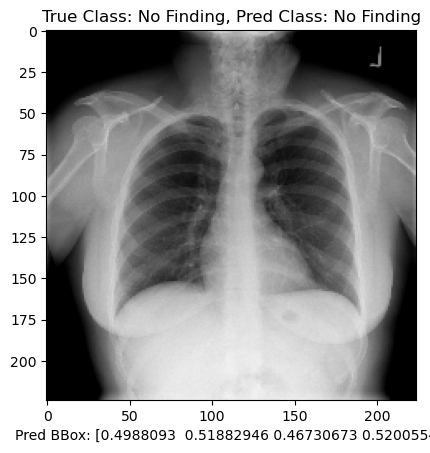

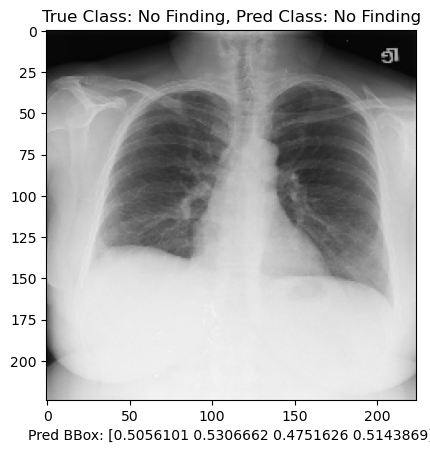

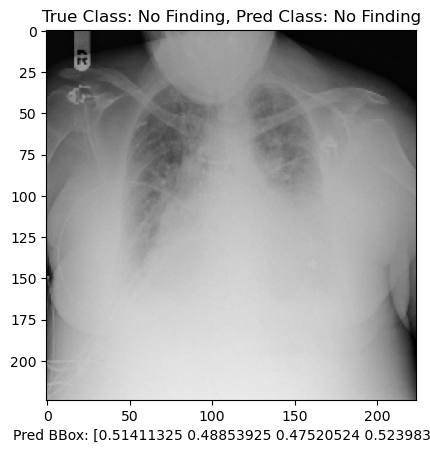

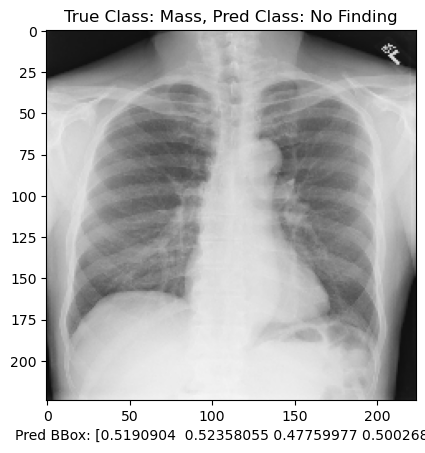

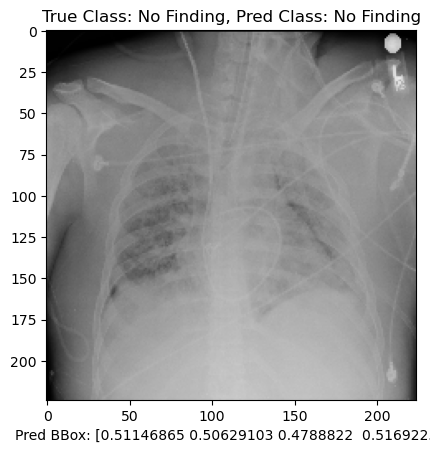

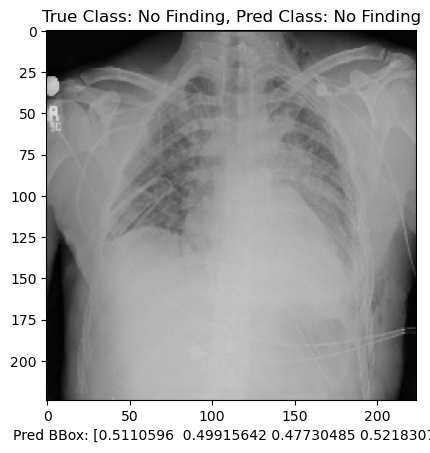

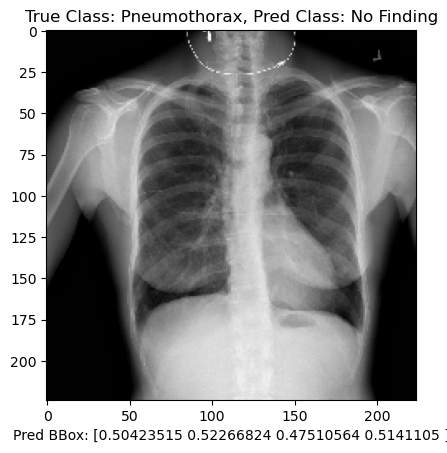

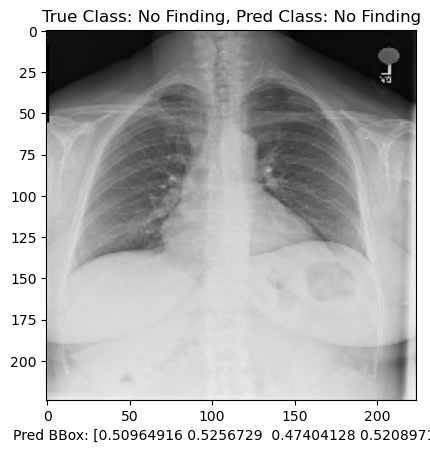

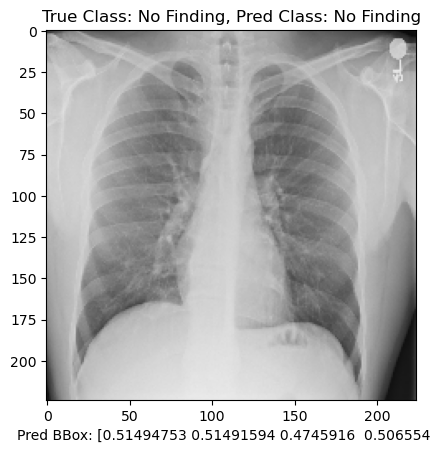

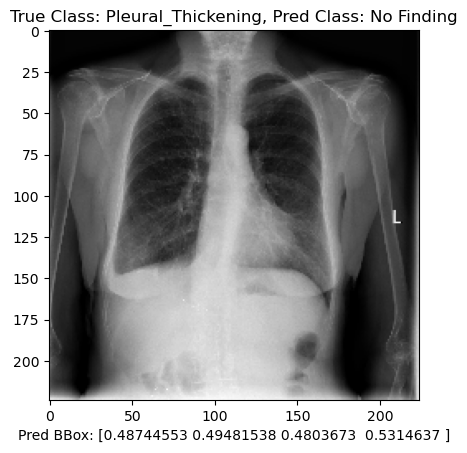

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [10]:
# Display some predictions
for i in range(10):
    plt.imshow(test_samples[i])
    plt.title(f"True Class: {categories[np.argmax(test_labels[i])]}, Pred Class: {categories[np.argmax(pred_class[i])]}")
    plt.xlabel(f"Pred BBox: {pred_bbox[i]}")
    plt.show()

# Plot the accuracy and loss graphs
plt.figure(figsize=(15,5))


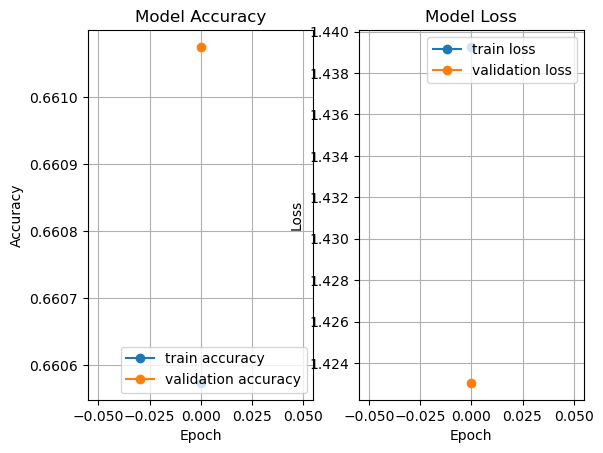

In [12]:
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['class_output_accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_class_output_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()